##Installing & Importing required Modules & Methods

In [ ]:
!pip install qiskit
!pip install qiskit-finance
!pip install qiskit-optimization
!pip install pylatexenc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
import plotly.graph_objects as go
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
import datetime
from copy import copy
from typing import List
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.finance.data_providers import RandomDataProvider,YahooDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.finance.applications.ising import portfolio
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization import QuadraticProgram
from docplex.mp.model import Model
from qiskit.circuit import Parameter, ParameterVector

     |████████████████████████████████| 6.1 MB 5.2 MB/s 
     |████████████████████████████████| 18.0 MB 113 kB/s 
     |████████████████████████████████| 235 kB 39.0 MB/s 
     |████████████████████████████████| 207 kB 53.7 MB/s 
     |████████████████████████████████| 2.1 MB 73.6 MB/s 
     |████████████████████████████████| 200 kB 71.9 MB/s 
     |████████████████████████████████| 1.4 MB 39.8 MB/s 
     |████████████████████████████████| 635 kB 72.4 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 943 kB 71.0 MB/s 
     |████████████████████████████████| 33.9 MB 19 kB/s 
     |████████████████████████████████| 3.0 MB 44.7 MB/s 
     |████████████████████████████████| 6.3 MB 55.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.29.0-py3-none-any.whl size=11179 sha256=e4f4faab35f836b9435cbefc8d74d9c048efae6ba3ed34ee9181ae8f307ba3c2
  Stored in directory: /root/.cache/pip/whe

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning:

The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>

/usr/local/lib/python3.7/dist-packages/qiskit/finance/__init__.py:50: DeprecationWarning:

The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>

/usr/local/lib/python3.7/dist-packages/qiskit/optimization/__init__.py:92: DeprecationWarning:

The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>



##Defining Quadtraic Problem

In [ ]:
# prepare problem instance
num_assets = 5  # number of assets (= number of qubits)   
q = 0.5          # risk factor
budget = num_assets // 2  # budget
penalty = 2*num_assets    # scaling of penalty term

In [ ]:
# Generate expected return and covariance matrix from (random) time-series
stocks=["BAC","IBM","PFE","TSLA","XOM"]

data = YahooDataProvider(tickers=stocks,
                 start=datetime.datetime(2015,1,1),
                 end=datetime.datetime(2020,12,31))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [ ]:
print("MU expected return", mu)
print("SIGMA is covariance", sigma)
print("Stock tickers", stocks)

MU expected return [ 0.00063765  0.00011569  0.00038236  0.00243455 -0.00020049]
SIGMA is covariance [[4.46155354e-04 1.96199715e-04 1.33808050e-04 2.01145479e-04
  2.35432983e-04]
 [1.96199715e-04 2.50413467e-04 1.04917982e-04 1.48370384e-04
  1.58216420e-04]
 [1.33808050e-04 1.04917982e-04 1.92167533e-04 8.62474536e-05
  9.93862476e-05]
 [2.01145479e-04 1.48370384e-04 8.62474536e-05 1.20799074e-03
  1.48357282e-04]
 [2.35432983e-04 1.58216420e-04 9.93862476e-05 1.48357282e-04
  3.05034809e-04]]
Stock tickers ['BAC', 'IBM', 'PFE', 'TSLA', 'XOM']


Covariance plot


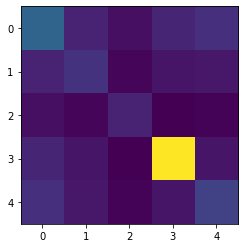

In [ ]:
# Covariant matrix plot -- shows correlation between equities
print("Covariance plot")
plt.imshow(sigma)
plt.show()

In [ ]:
# create docplex model
mdl = Model('portfolio_optimization')
x = mdl.binary_var_list('x{}'.format(i) for i in range(num_assets))
objective = mdl.sum([mu[i]*x[i] for i in range(num_assets)])
objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(num_assets) for j in range(num_assets)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(num_assets)) == budget)


qp = QuadraticProgram()
qp.from_docplex(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio_optimization

Maximize
 obj: 0.000637651719 x0 + 0.000115690051 x1 + 0.000382356341 x2
      + 0.002434552865 x3 - 0.000200487688 x4 + [ - 0.000446155354 x0^2
      - 0.000392399431 x0*x1 - 0.000267616101 x0*x2 - 0.000402290957 x0*x3
      - 0.000470865965 x0*x4 - 0.000250413467 x1^2 - 0.000209835965 x1*x2
      - 0.000296740768 x1*x3 - 0.000316432839 x1*x4 - 0.000192167533 x2^2
      - 0.000172494907 x2*x3 - 0.000198772495 x2*x4 - 0.001207990736 x3^2
      - 0.000296714564 x3*x4 - 0.000305034809 x4^2 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 + x4 = 2

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:

The from_docplex method is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_optimization.translators.from_docplex_mp function.



## Defining QAOA Circuit

In [ ]:
def create_qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()
    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)
   
    #Outer loop to create each layer
    for i in range(p):

        #Apply R_Z rotational gates from cost layer
        for j in range(size):
            qubo_matrix_sum_of_col = 0
            for k in range(size):
                qubo_matrix_sum_of_col += qubo_matrix[j][k]
            
            qaoa_circuit.rz(gammas[i]*(qubo_linearity[j]+qubo_matrix_sum_of_col),j)
                
        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            for k in range(size):
                if j != k:
                    qaoa_circuit.rzz(gammas[i]*qubo_matrix[j][k]*0.5,j,k)
        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        #INSERT YOUR CODE HERE
        for j in range(size):
            qaoa_circuit.rx(2 * betas[i], j)
            
    return qaoa_circuit

##Getting the Sharpe Ratio & Portfolio Weight using Numerical Analytics

In [ ]:
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
selection = opt_result.x
purchase = []
for j in range(num_assets):
  if selection[j] == 1:
    purchase.append(stocks[j])
print("sharpe_ratio :"+"{:.2%}".format(opt_result.fval))
print("Optimal Selection of Stocks:",purchase)


sharpe_ratio :0.20%
Optimal Selection of Stocks: ['BAC', 'TSLA']


In [ ]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

##Caluclating Sharpe Ratio & Portfolio Weight using CVaR adaption of QAOA

In [ ]:
def get_expectation(qp: QuadraticProgram, p : int, cvar: float = None):
    num_shots = 1000
    seed = 42
    num_assets=5
    simulator = Aer.get_backend('qasm_simulator')
    simulator.set_options(seed_simulator = 42)

    #Generate circuit
    circuit = create_qaoa_circuit(qp, p=1)
    for i in range(num_assets):
      circuit.measure(i,i)

    #Create dictionary with precomputed cut values for all bitstrings 
    obj_values = {}
    size =num_assets
    for i in range(2**size):
        bitstr = '{:b}'.format(i).rjust(size, '0')[::-1]
        x = [int(bit) for bit in bitstr]
        # obj_values[bitstr] =  QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        obj_values[bitstr] =  qp.objective.evaluate(x)
         #Perform grid search over all parameters
    data_points = []
    max_sharpe_ratio = None
    for beta in np.linspace(0,np.pi, 50):
        for gamma in np.linspace(0, 4*np.pi, 50):
            bound_circuit = circuit.assign_parameters([beta, gamma])
            result = simulator.run(bound_circuit, shots = num_shots).result()
            statevector = result.get_counts(bound_circuit)
            sharpe_ratio = 0
            measured_cuts = []
            for bitstring, count in statevector.items():
                measured_cuts =  measured_cuts + [obj_values[bitstring]]*count

            if cvar is None:
                #Calculate the mean of all cut values
                sharpe_ratio = sum(measured_cuts)/num_shots
            else:
                #raise NotImplementedError()
                #INSERT YOUR CODE HERE
                measured_cuts = sorted(measured_cuts, reverse=True)
                for i in range(int(np.ceil(cvar*num_shots))):
                    sharpe_ratio+=measured_cuts[i]
                sharpe_ratio = sharpe_ratio / int(np.ceil(cvar*num_shots))
            #Update optimal parameters
            if max_sharpe_ratio is None or sharpe_ratio > max_sharpe_ratio:
                max_sharpe_ratio = sharpe_ratio
                selection = sample_most_likely(statevector)
                purchase = []
                for j in range(num_assets):
                  if selection[j] == 1:
                    purchase.append(stocks[j])
                optimum = {'beta': beta, 'gamma': gamma, 'sharpe_ratio': "".join([str(round((sharpe_ratio*100),3)),"%"]),'selection': purchase}
             #Update data
            data_points.append({'beta': beta, 'gamma': gamma, 'sharpe_ratio': sharpe_ratio})


    #Create and display surface plot from data_points
    df = pd.DataFrame(data_points)
    df = df.pivot(index='beta', columns='gamma', values='sharpe_ratio')
    matrix = df.to_numpy()
    beta_values = df.index.tolist()
    gamma_values = df.columns.tolist()

    surface_plot = go.Surface(
        x=gamma_values, 
        y=beta_values,
        z=matrix,
        coloraxis = 'coloraxis'
    )
    fig = go.Figure(data = surface_plot)
    fig.show()

    #Return optimum
    return optimum


##Getting the Sharpe Ratio & Portfolio Weight using CVaR adaption of QAOA with different values of cvar fraction (aplha)

In [ ]:
#Without CVAR
print(get_expectation(qp,p=1))

{'beta': 1.2822827157509358, 'gamma': 5.385587406153931, 'sharpe_ratio': '-376.933%', 'selection': ['IBM', 'TSLA']}


In [ ]:
print(get_expectation(qp,p=1,cvar=0.05))

{'beta': 0.0641141357875468, 'gamma': 3.5903916041026207, 'sharpe_ratio': '0.204%', 'selection': ['BAC', 'IBM', 'PFE', 'TSLA']}


In [ ]:
print(get_expectation(qp,p=1,cvar=0.2))

{'beta': 1.3463968515384828, 'gamma': 1.7951958020513104, 'sharpe_ratio': '0.196%', 'selection': ['BAC', 'PFE']}


In [ ]:
print(get_expectation(qp,p=1,cvar=0.5))

{'beta': 1.3463968515384828, 'gamma': 1.7951958020513104, 'sharpe_ratio': '0.128%', 'selection': ['BAC', 'PFE']}


In [ ]:
print(get_expectation(qp,p=1,cvar=0.7))

{'beta': 1.3463968515384828, 'gamma': 1.7951958020513104, 'sharpe_ratio': '0.09%', 'selection': ['BAC', 'PFE']}


In [ ]:
print(get_expectation(qp,p=1,cvar=1.0))

{'beta': 1.2822827157509358, 'gamma': 5.385587406153931, 'sharpe_ratio': '-376.933%', 'selection': ['IBM', 'TSLA']}
